In [1]:
import sys, time, cProfile, pstats, importlib, os, itertools
sys.path.insert(0,'/home/uq/apps/muq2inst/lib')
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 10.)
matplotlib.rcParams.update({'font.size': 22})

import pymuqUtilities as mu

import plotutil

from GaussianPosterior import GaussianPosterior
from DeepTransportMap import *

def compute(indices) :
    (i,j,k) = indices
    start = time.process_time()
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    st = time.process_time() - start

    start = time.process_time()
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    l2 = np.sqrt(np.sum((true_target - density)**2))/norm
    et = time.process_time() - start

    return i, j, k, l2, st, et


def plot_results(noise, x_multis, results_l2, results_st, results_et) :
    fig = plt.figure()
    fig.suptitle('noise = {}'.format(noise), fontsize=20)

    ax = plotutil.get_ax(fig, 3, 1, title='L2 error', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    for i in range(len(temps)) :
        ax.errorbar(x_multis, np.mean(results_l2[i], axis=1), yerr=np.std(results_l2[i], axis=1), capsize=5, label='L = '+str(i))
    ax.legend()

    ax = plotutil.get_ax(fig, 3, 2, title='setup time', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    for i in range(len(temps)) :
        ax.errorbar(x_multis, np.mean(results_st[i], axis=1), yerr=np.std(results_st[i], axis=1), capsize=5, label='L = '+str(i))
    ax.legend()

    ax = plotutil.get_ax(fig, 3, 3, title='eval time', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    for i in range(len(temps)) :
        ax.errorbar(x_multis, np.mean(results_et[i], axis=1), yerr=np.std(results_et[i], axis=1), capsize=5, label='L = '+str(i))
    ax.legend()

    plt.tight_layout()
    plt.show()

In [2]:
epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003, .0000007, .00000002]
[mu.MultiIndexFactory.CreateAnisotropic([.7], eps).Size() for eps in epslns]

[3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50]

In [6]:
[mu.MultiIndexFactory.CreateAnisotropic([.15, .15], 1/(10**i)).Size() for i in range(2,9)]

[6, 10, 15, 28, 36, 45, 55]

temps:  [[1], [0.1, 1], [0.01, 0.1, 1], [0.001, 0.01, 0.1, 1]]
x_multis: [3, 4, 5, 7, 9, 12, 15, 20, 30]


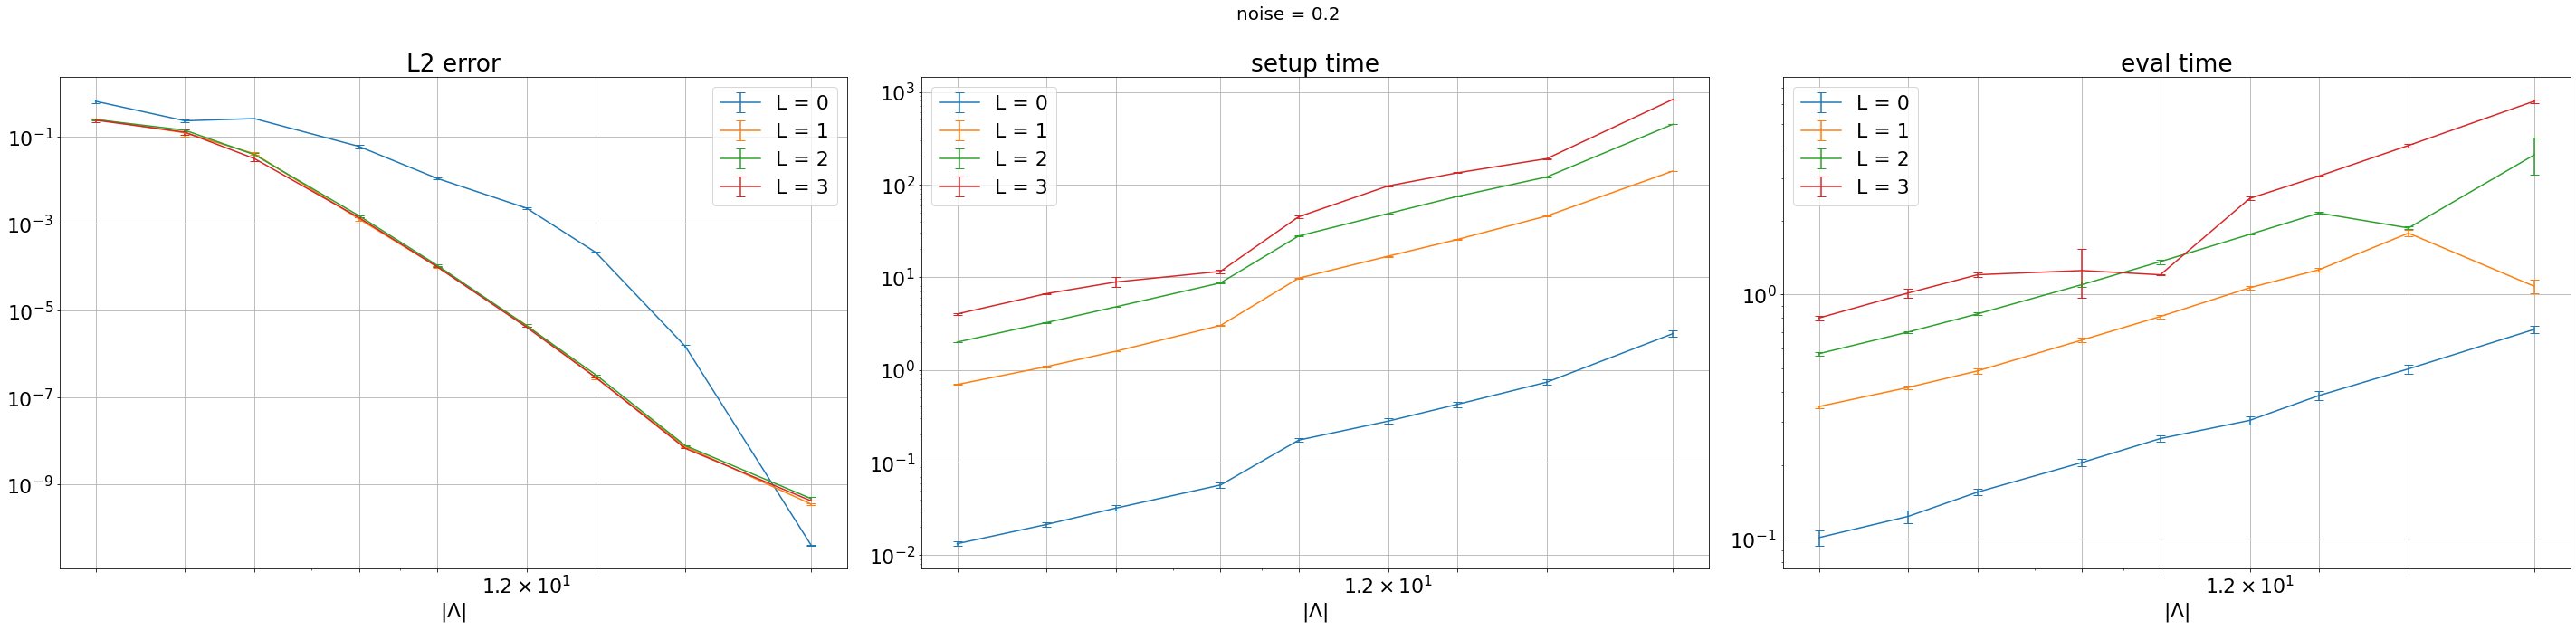

In [3]:
noise = .2
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
L_max = 4
n_runs = 4 
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[10**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.1, 1], [0.01, 0.1, 1]]
x_multis: [3, 4, 5, 7, 9, 12, 15, 20, 30]


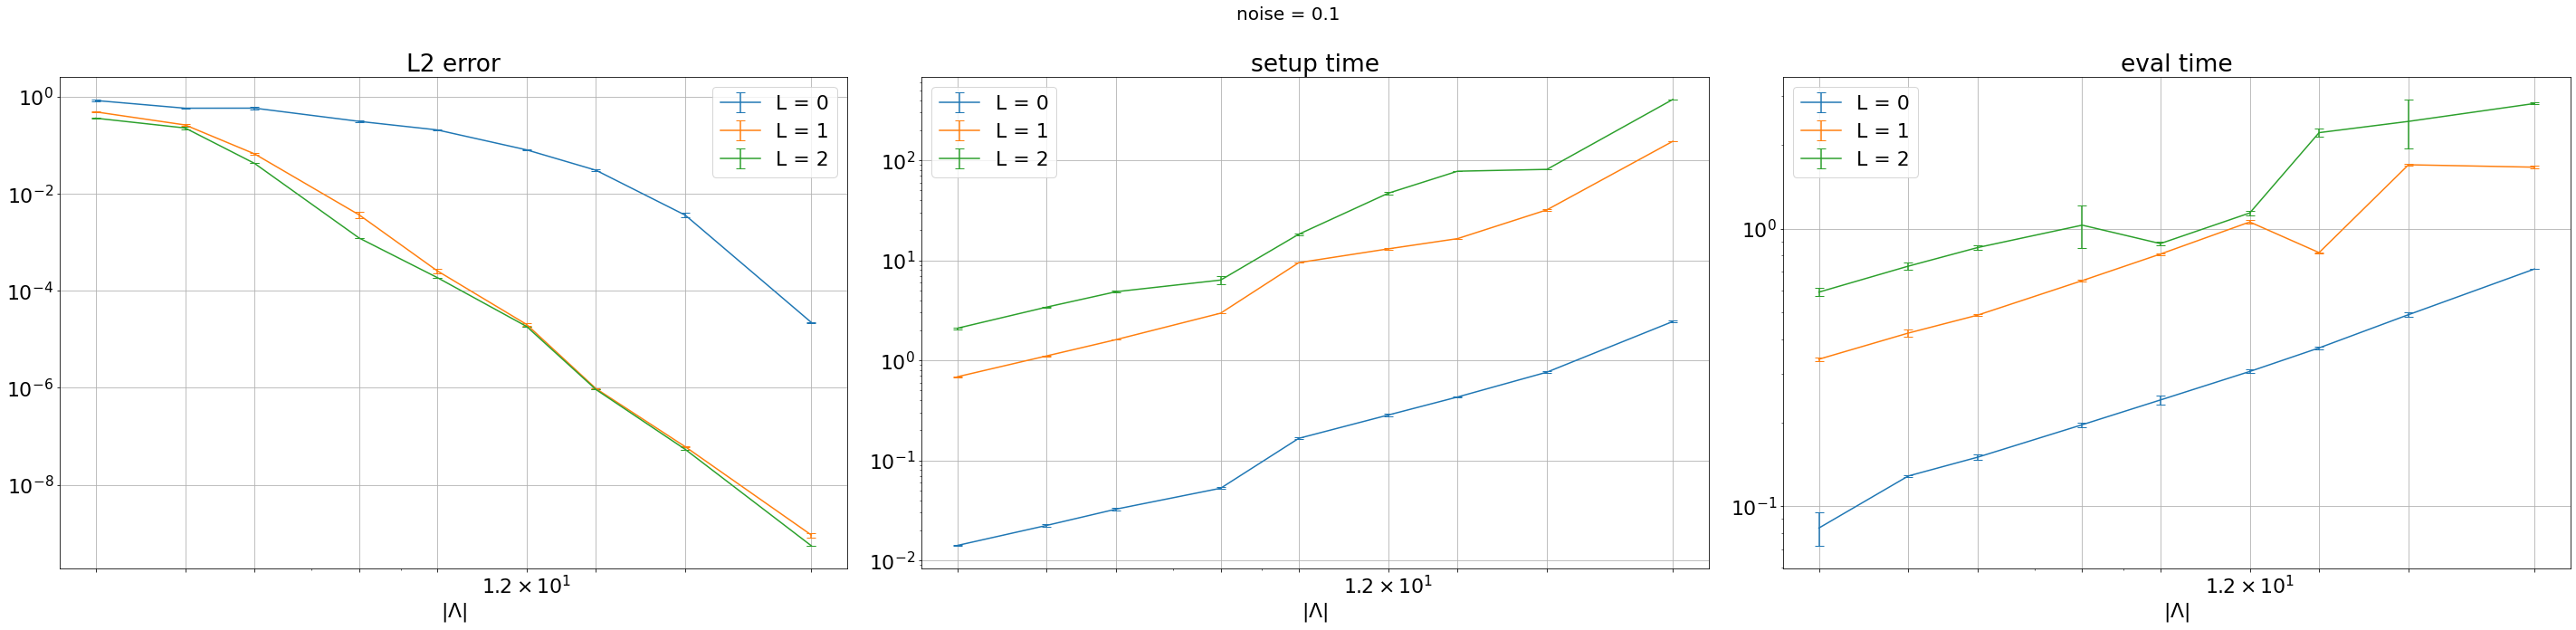

In [4]:
noise = .1
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
L_max = 3
n_runs = 4 
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[10**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.1, 1], [0.01, 0.1, 1]]
x_multis: [3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50]


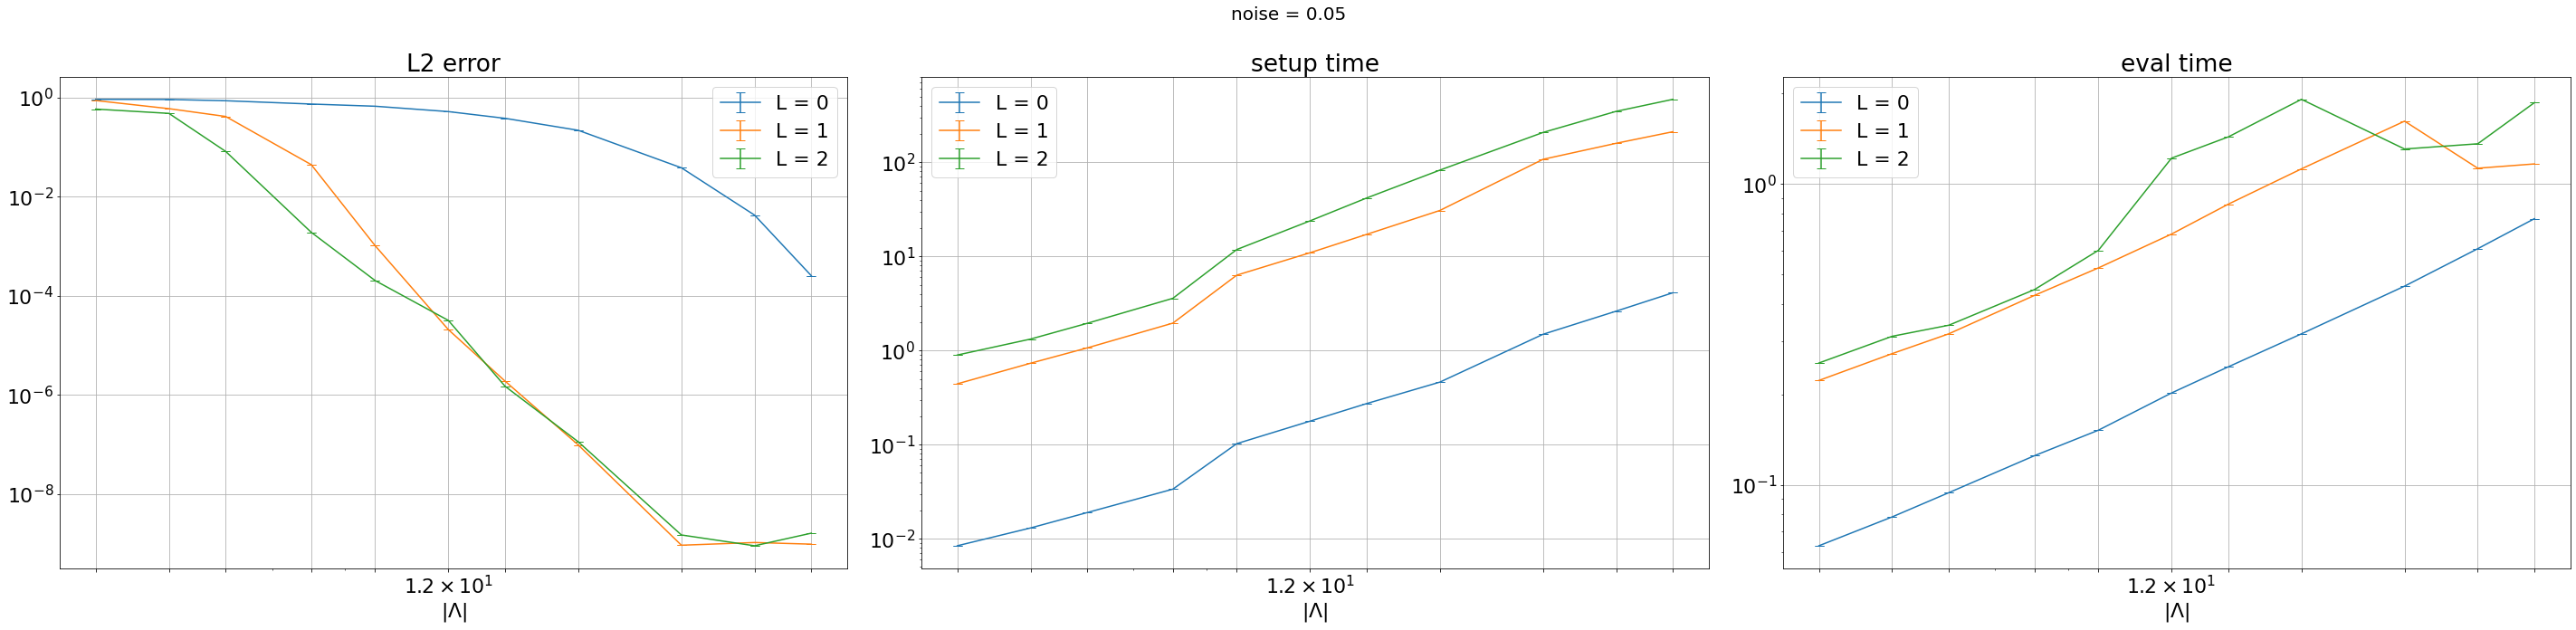

In [27]:
noise = .05
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
L_max = 3
n_runs = 1
n_samples = 200
x_multis = [m.Size() for m in multis]
temps = [[10**(-L+n) for n in range(L+1)] for L in range(L_max)]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.1, 1], [0.01, 0.1, 1]]
x_multis: [3, 4, 5, 7, 9, 12, 15, 20, 30]


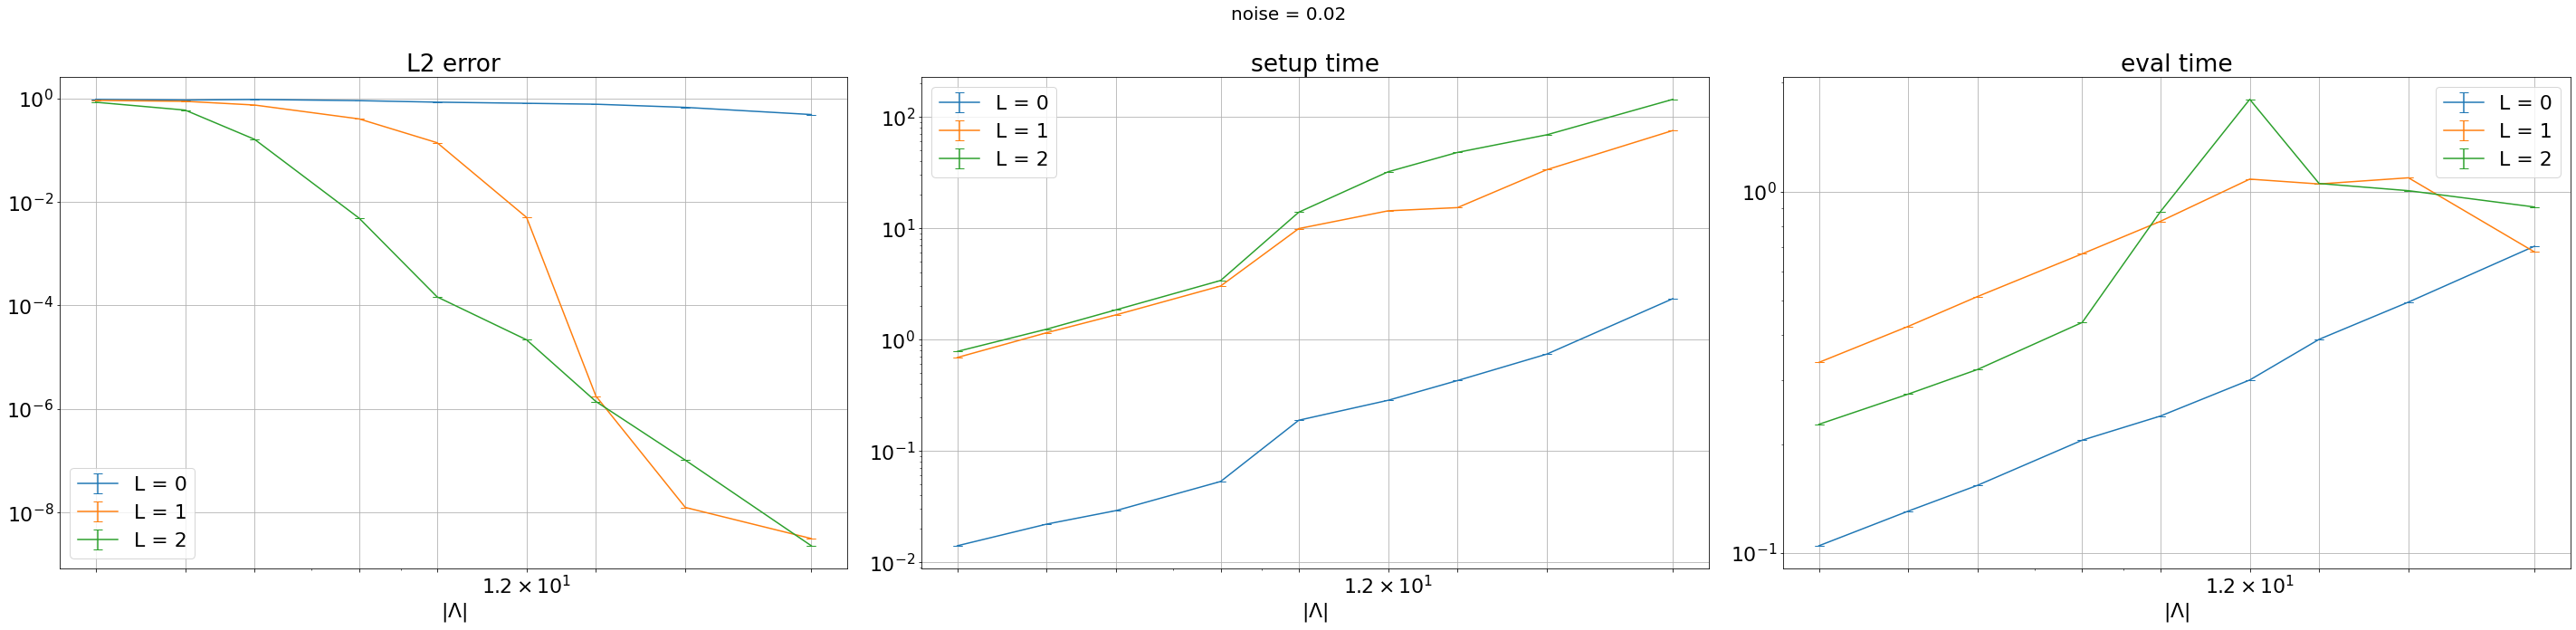

In [7]:
noise = .02
L_max = 3
n_runs = 1
n_samples = 200
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.1, 1], [0.01, 0.1, 1], [0.001, 0.01, 0.1, 1]]
x_multis: [3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50]


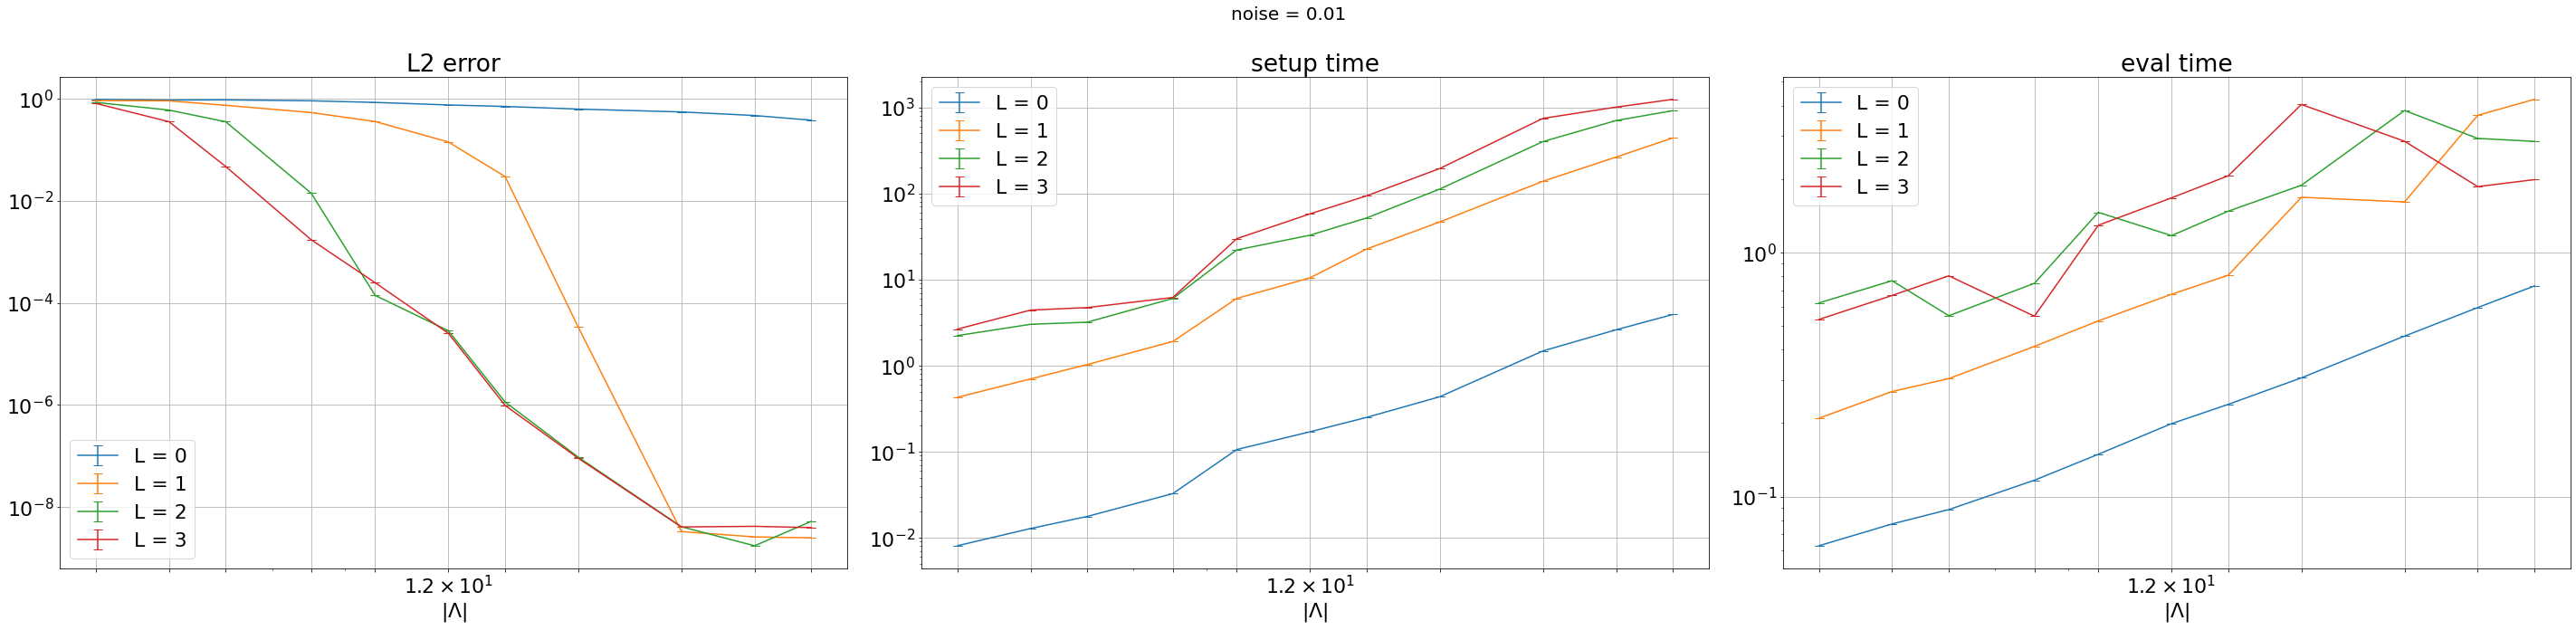

In [26]:
noise = .01
L_max = 4
n_runs = 1
n_samples = 200
temps = [[10**(-L+n) for n in range(L+1)] for L in range(L_max)]
epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003, .0000007, .00000002]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
x_multis = [m.Size() for m in multis]
print('temps: ', temps)
print('x_multis:', x_multis)

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

temps:  [[1], [0.1, 1], [0.01, 0.1, 1], [0.001, 0.01, 0.1, 1]]
x_multis: [3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50]


/home/uq/spatram/TransportMap.py:42: RuntimeWarning: invalid value encountered in double_scalars
  S[i] = 2*r/s - 1
/home/uq/spatram/TransportMap.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return self.density(x) / self.norm


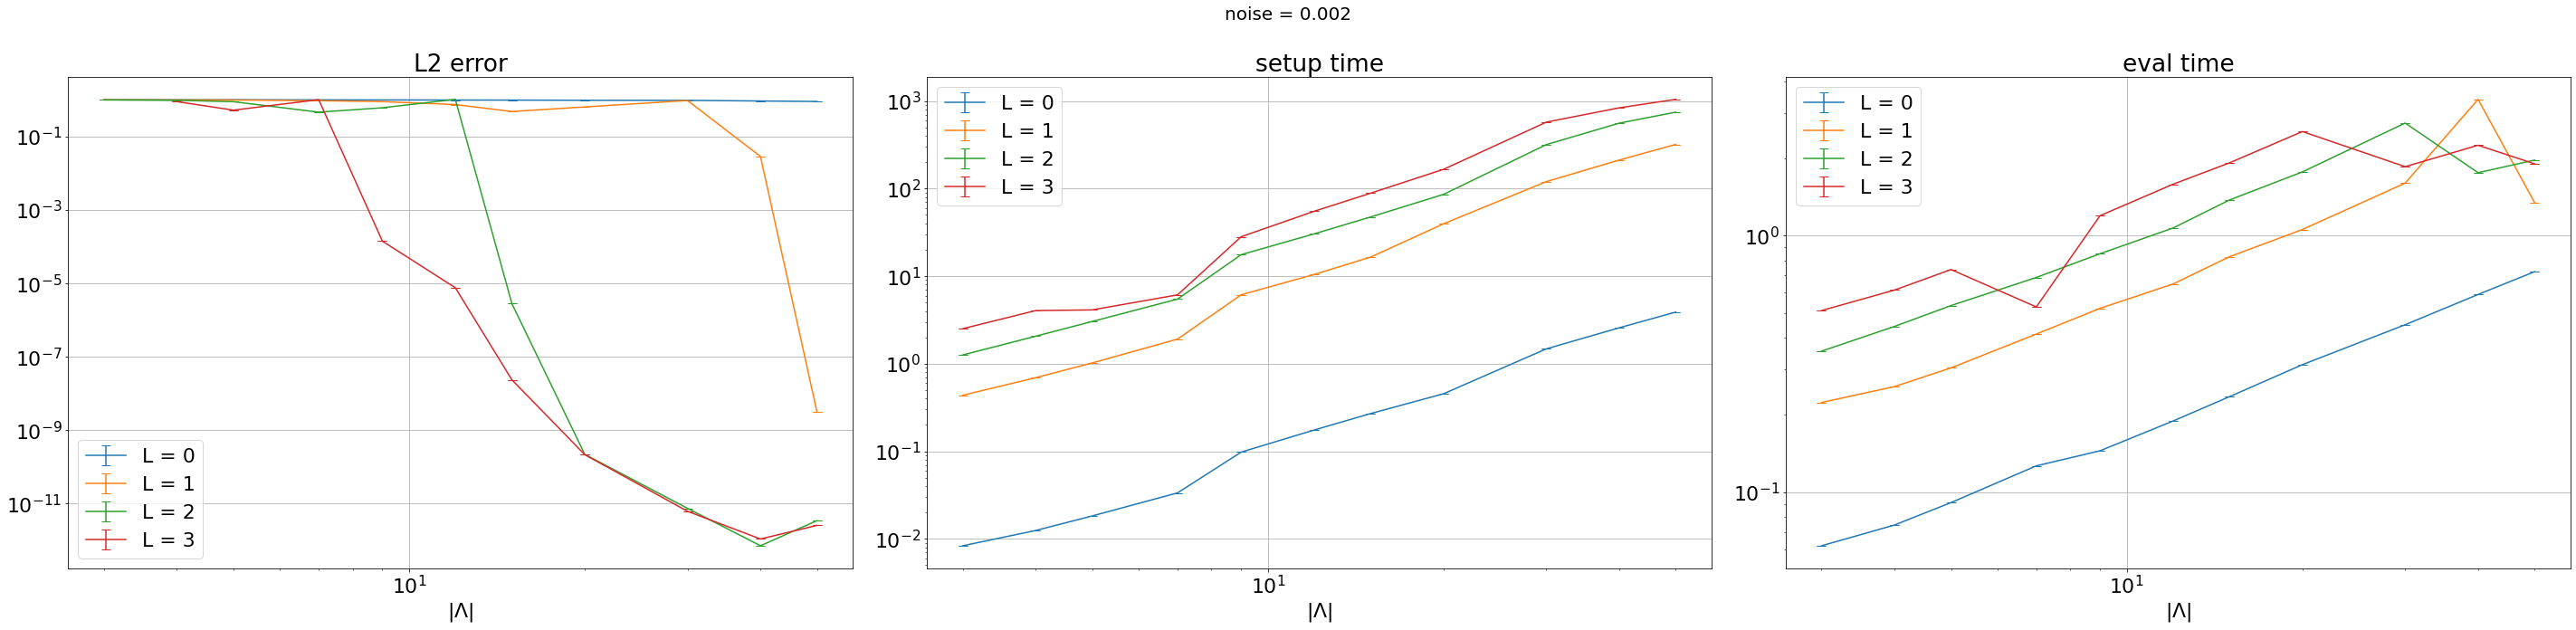

In [4]:
noise = .002
L_max = 4
n_runs = 1
n_samples = 200
temps = [[10**(-L+n) for n in range(L+1)] for L in range(L_max)]
epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003, .0000007, .00000002]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
x_multis = [m.Size() for m in multis]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

results_l2 = np.zeros((len(temps), len(multis), n_runs))
results_st = np.zeros((len(temps), len(multis), n_runs))
results_et = np.zeros((len(temps), len(multis), n_runs))

with ProcessPoolExecutor(max_workers=8) as executor:
    iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute, iterable))
    for (i, j, k, l2, st, et) in results :
        results_l2[i,j,k] = l2
        results_st[i,j,k] = st
        results_et[i,j,k] = et

plot_results(noise, x_multis, results_l2, results_st, results_et)

In [28]:
def compute_l2(indices) :
    (i,j,k) = indices
    deeptm = DeepTransportMap(1, target, temps[i], multis[j], 'wls')
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    print(i,j,k)
    return i, j, k, np.sqrt(np.sum((true_target - density)**2))/norm

L_max = 4
n_runs = 3
n_samples = 100
temps = [[10**(-L+n) for n in range(L+1)] for L in range(L_max)]
epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003, .0000007, .00000002]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
x_multis = [m.Size() for m in multis]
print('temps: ', temps)
print('x_multis:', x_multis)

points = np.random.uniform(low=-1, high=1, size=(n_samples,1))

noise_list = [.1, .01, .005] 
result_list = []
for noise in noise_list :
    print(noise)
    target = GaussianPosterior(noise=noise , y_measurement=[.4])
    true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
    true_target /= np.sum(true_target)
    norm = np.sqrt(np.dot(true_target, true_target))

    results_l2 = np.zeros((len(temps), len(multis), n_runs))

    with ProcessPoolExecutor(max_workers=7) as executor:
        iterable = itertools.product(range(len(temps))[::-1], range(len(multis))[::-1], range(n_runs)[::-1])
        results = list(executor.map(compute_l2, iterable))
        for (i, j, k, l2) in results :
            results_l2[i,j,k] = l2

    result_list.append(results_l2)

temps:  [[1], [0.1, 1], [0.01, 0.1, 1], [0.001, 0.01, 0.1, 1]]
x_multis: [3, 4, 5, 7, 9, 12, 15, 20, 30, 40, 50]
0.1
3 8 2
3 9 0
3 9 2
3 9 1
3 8 1
3 7 2
3 7 0
3 6 2
3 7 1
3 6 1
3 6 0
3 5 2
3 4 2
3 5 1
3 4 1
3 5 0
3 3 2
3 3 1
3 3 0
3 2 1
3 2 2
3 2 0
3 1 2
3 4 0
3 1 1
3 0 1
3 31  00
 2
3 0 0
3 8 0
3 10 1
3 10 2
3 10 0
2 9 2
2 8 2
2 10 1
2 8 1
2 10 0
2 7 2
2 7 1
2 6 2
2 6 1
2 10 2
2 7 0
2 5 2
2 9 1
2 5 1
2 9 0
2 6 0
2 5 0
2 3 2
2 3 1
2 4 1
2 4 2
22  22  2
1
2 2 0
2 1 2
2 3 0
2 1 0
2 0 2
2 0 1
2 1 1
2 0 0
2 4 0
2 8 0
1 8 2
1 9 2
1 9 0
1 9 1
1 8 1
1 7 2
1 7 1
1 7 0
1 6 2
1 6 1
1 6 0
1 5 2
1 5 1
1 4 2
1 4 1
1 5 0
1 3 2
1 3 1
1 2 2
1 4 0
1 3 0
1 1 2
1 2 1
1 2 0
1 1 1
1 0 2
1 1 0
1 0 1
1 0 0
0 10 2
0 10 1
0 10 0
0 9 2
0 9 1
0 9 0
0 8 2
0 8 1
0 8 0
0 7 2
0 7 1
0 07 0
 6 2
0 6 01 
5 2
0 6 0
0 5 1
0 5 0
0 4 2
0 03 2
 4 1
0 4 0
0 30 1
 0 3 0
2 2
0 2 1
0 02 1 2 
0
0 1 0 010
 1 0
 2
0 0 01 
0 0
1 10 1
1 8 0
1 10 0
1 10 2
0.01
3 8 2
3 9 1
3 8 1
3 9 2
3 9 0
3 7 2
3 7 1
3 7 0
3 6 1
3 6 2
3 6 0
3 5 2
3 

/home/uq/spatram/TransportMap.py:42: RuntimeWarning: invalid value encountered in double_scalars
  S[i] = 2*r/s - 1
/home/uq/spatram/TransportMap.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return self.density(x) / self.norm


2 1 2
2 3 0
2 0 22 
2 0
2 1 1
2 0 1
2 1 0
2 0 0
2 8 0
1 8 2
1 9 1
1 9 0
1 7 2
1 9 2
1 7 1
1 8 1
1 6 2
1 7 0
1 6 1
1 5 2
1 6 0
1 4 2
1 5 0
1 5 1
1 3 2
1 4 1
1 3 1
1 4 10 8
 0
1 2 1
1 3 0
1 2 2
1 2 0
1 1 2
1 1 0
1 1 1
1 0 2
1 0 1
1 0 0
0 9 2
0 10 2
0 10 1
0 10 0
0 8 2
0 8 1
0 9 1
0 9 0
0 7 1
0 7 2
0 6 2
0 7 0
0 8 0
0 6 1
0 5 2
0 0 5 1
6 0
0 5 0
0 4 2
0 04  31 
2
0 4 00
 3 1
0 0 3 2 0
02 2 1

00 1  20 2
01  0
1  

/home/uq/spatram/TransportMap.py:79: RuntimeWarning: invalid value encountered in double_scalars
  return self.density(x) / self.norm


0
1
0 0 0 20 
1
0 0 0
1 10 2
1 10 1
1 10 0


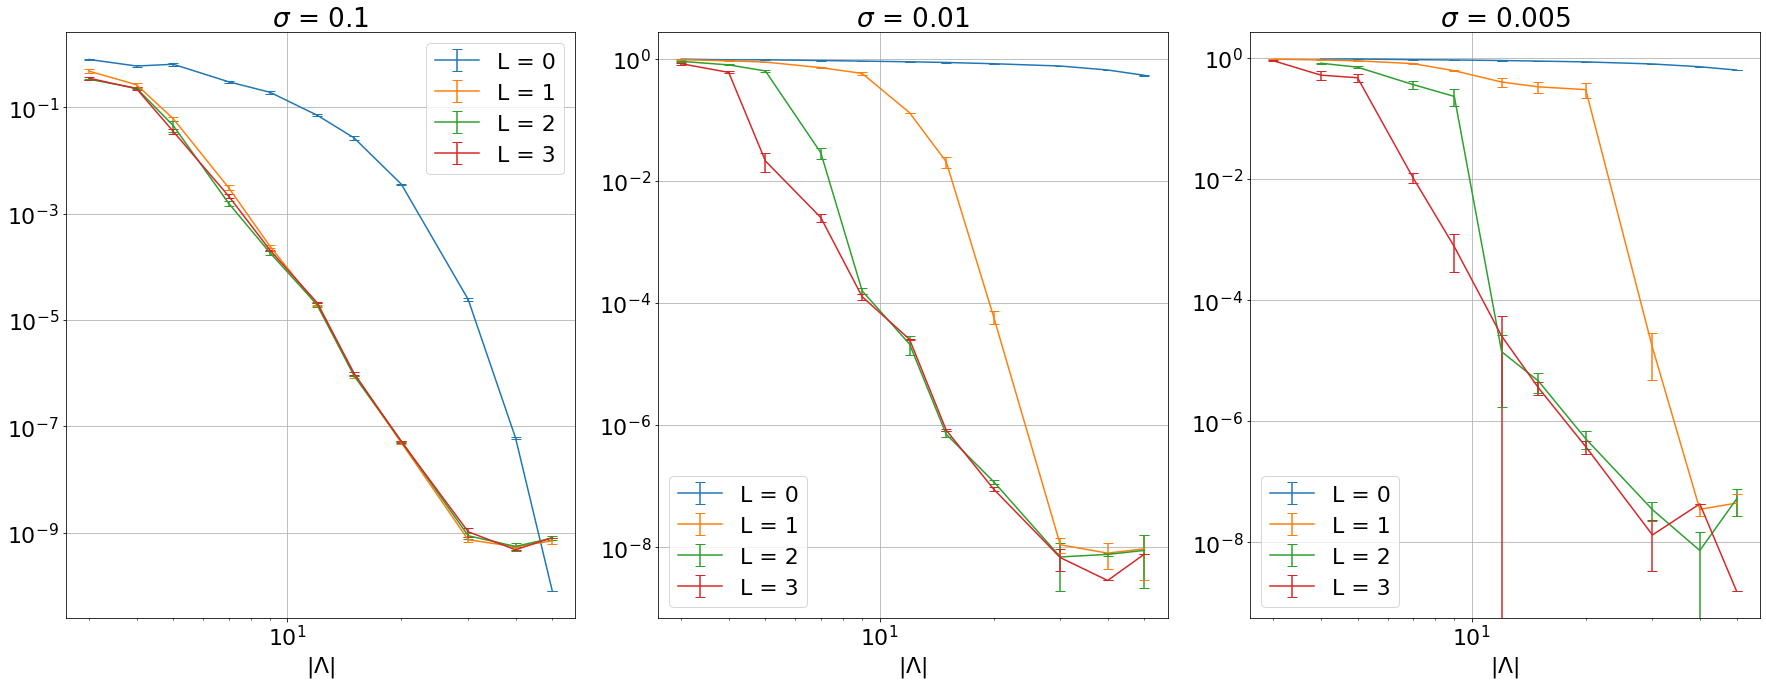

In [34]:
def plot_results_summary(noise_list, x_multis, results) :
    fig = plt.figure(figsize=(25,10))
    #fig.suptitle('L2 error')

    n = len(noise_list)
    for j in range(n) :
        ax = plotutil.get_ax(fig, n, j+1, title=r'$\sigma$ = {}'.format(noise_list[j]), xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
        results_l2 = results[j]
        for i in range(len(temps)) :
            ax.errorbar(x_multis, np.mean(results_l2[i], axis=1), yerr=np.std(results_l2[i], axis=1), capsize=5, label='L = '+str(i))
        ax.legend()

    plt.tight_layout()
    plt.savefig('dirt_l2_lambda.pdf', format='pdf')
    plt.show()
    
plot_results_summary(noise_list, x_multis, result_list)

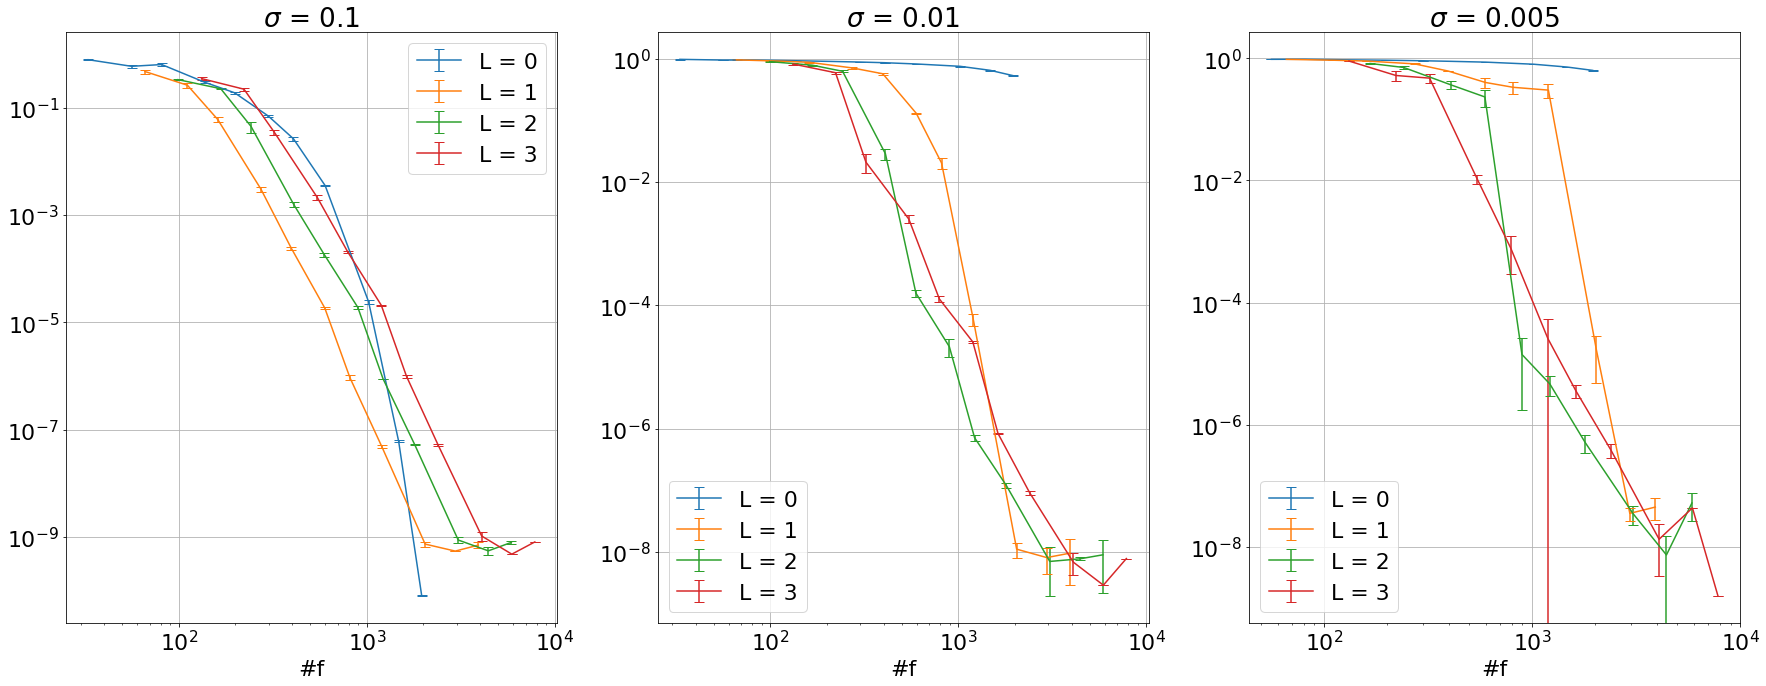

In [35]:
def plot_results_summary(noise_list, x_multis, results) :
    fig = plt.figure(figsize=(25,10))
    #fig.suptitle('L2 error')

    n = len(noise_list)
    for j in range(n) :
        ax = plotutil.get_ax(fig, n, j+1, title=r'$\sigma$ = {}'.format(noise_list[j]), xlabel='#f', logaxis=['x', 'y'])
        results_l2 = results[j]
        for i in range(len(temps)) :
            x = [int(np.ceil((i+1)*10*xi*np.log(xi))) for xi in x_multis]
            ax.errorbar(x, np.mean(results_l2[i], axis=1), yerr=np.std(results_l2[i], axis=1), capsize=5, label='L = '+str(i))
        ax.legend()
    
    plt.tight_layout()
    plt.savefig('dirt_l2_n_calls.pdf', format='pdf')
    plt.show()
    
plot_results_summary(noise_list, x_multis, result_list)

In [53]:
noise = .01
n_runs = 3
result_collection = dict()

epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
x_multis = [m.Size() for m in multis]

points = np.random.uniform(low=-1, high=1, size=(200,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

def compute_l2(indices) : 
    (j,k) = indices
    deeptm = DeepTransportMap(1, target, temps, multis[j], 'wls')
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    print(j,k)
    return j, k, np.sqrt(np.sum((true_target - density)**2))/norm

In [73]:
temps = [.1, 1.]

results_l2 = np.zeros((len(multis), n_runs))
with ProcessPoolExecutor(max_workers=7) as executor:
    iterable = itertools.product(range(len(multis))[::-1], range(n_runs)[::-1])
    results = list(executor.map(compute_l2, iterable))
    for (j, k, l2) in results :
        results_l2[j,k] = l2

result_collection[repr(temps)] = results_l2

6 2
7 2
7 1
7 0
6 1
5 2
5 1
5 0
6 0
4 2
4 1
3 2
2 2
3 1
4 0
3 0
1 2
2 1
2 0
1 1
1 0
0 2
0 1
0 0
8 2
8 1
8 0


[0.25, 0.5, 1.0] 3
[0.1, 1.0] 2
[0.02, 0.01, 1.0] 3
[0.01, 1.0] 2
[0.01, 0.1, 1.0] 3
[0.01, 0.02, 1.0] 3
[0.01, 0.01, 1.0] 3
[0.001, 0.01, 1.0] 3
[0.001, 0.01, 0.1, 1.0] 4


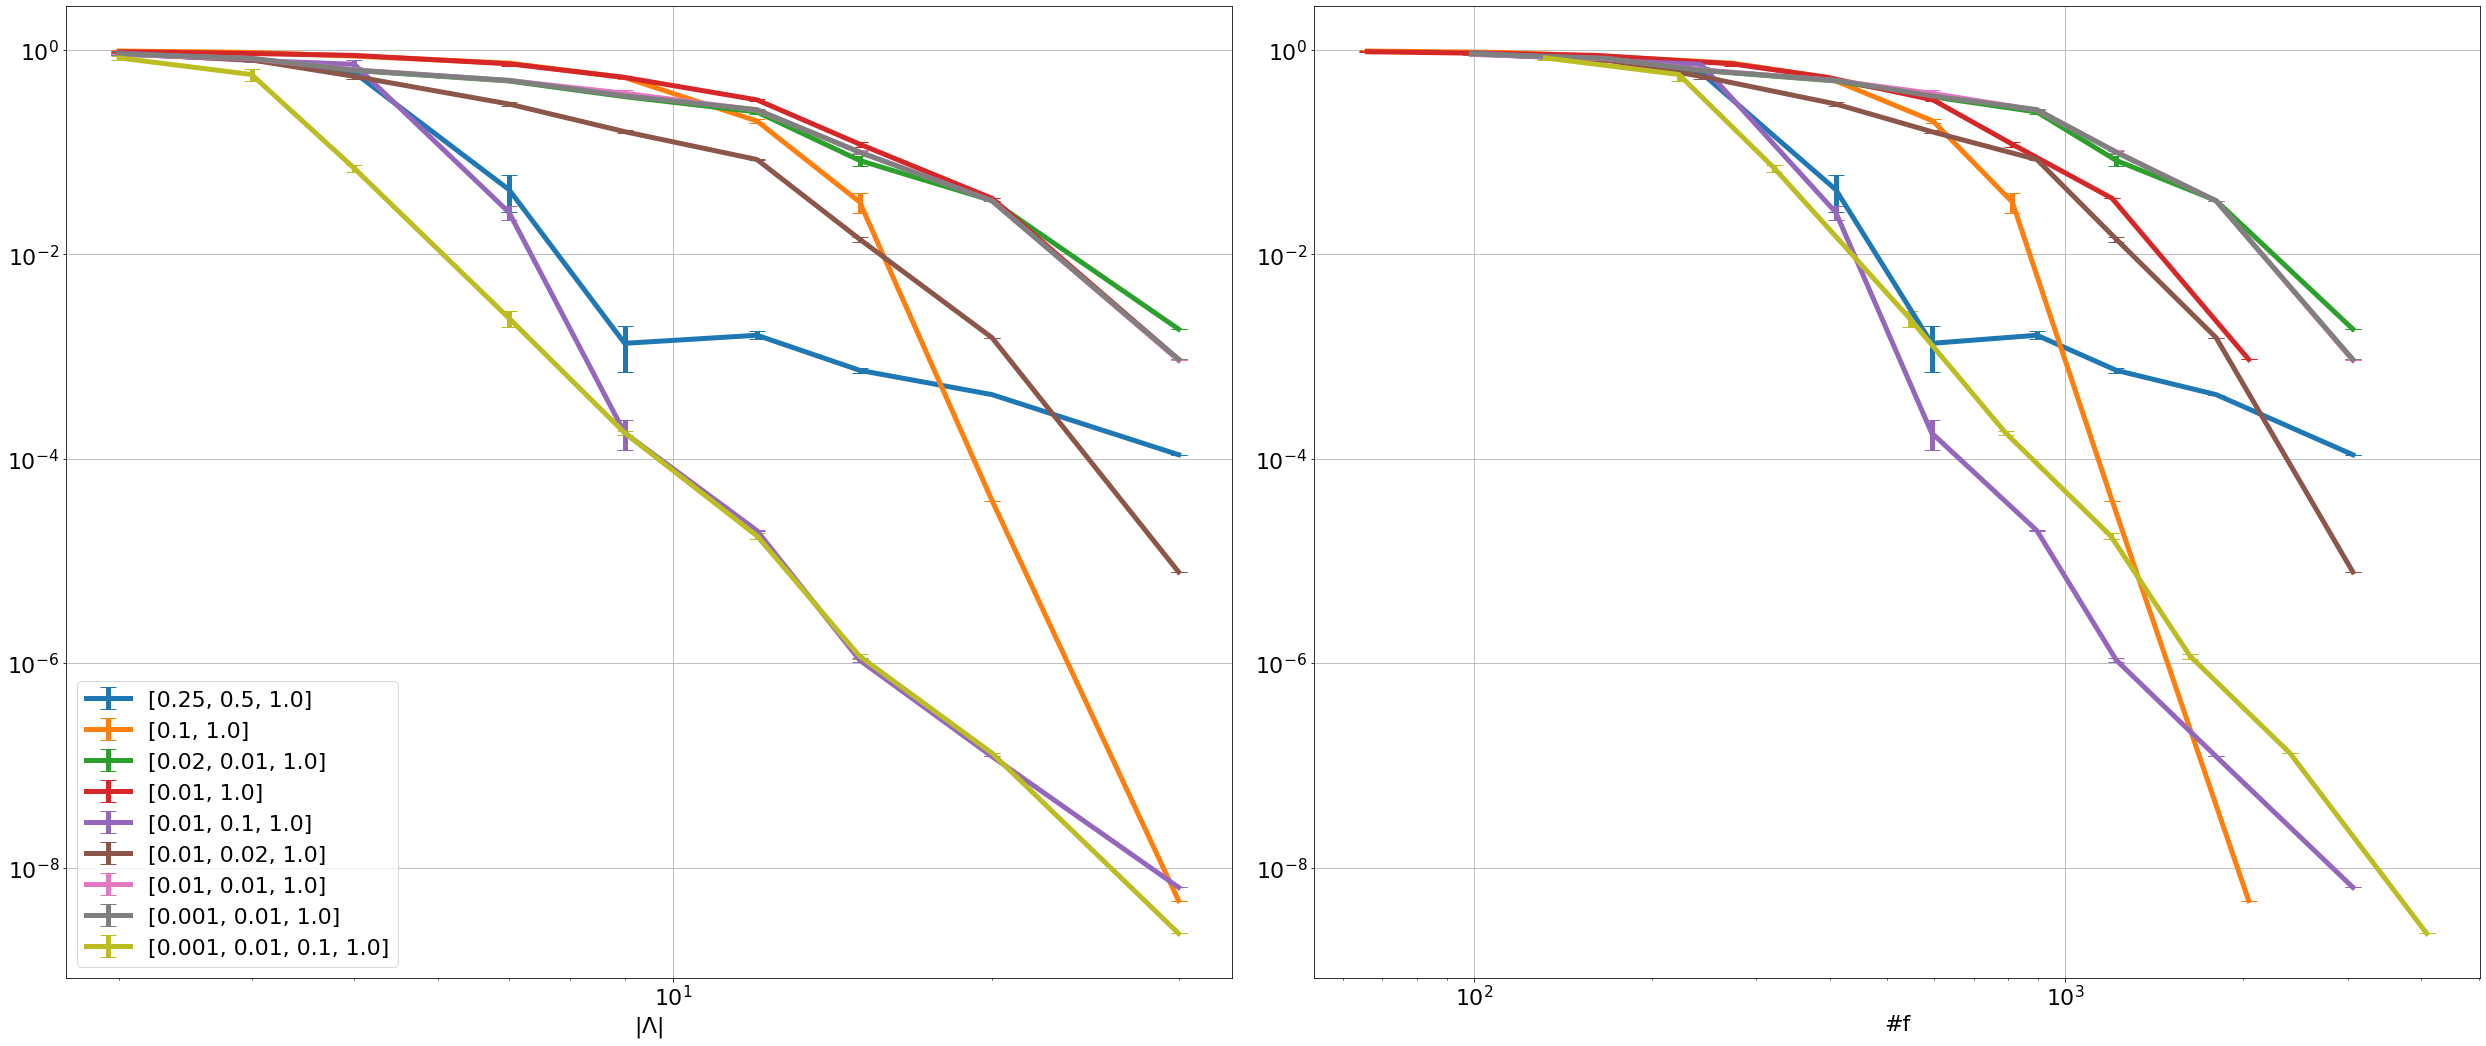

In [74]:
def plot_result_collection(result_collection, x_multis) :
    fig = plt.figure(figsize=(35,15))
    ax1 = plotutil.get_ax(fig, 2, 1, title='', xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    ax2 = plotutil.get_ax(fig, 2, 2, title='', xlabel='#f', logaxis=['x', 'y'])

    for temps in sorted(result_collection.keys())[::-1] :
        print(temps, len(eval(temps)))
        results_l2 = result_collection[temps]
        x = [int(np.ceil(len(eval(temps))*10*xi*np.log(xi))) for xi in x_multis]
        ax1.errorbar(x_multis, np.mean(results_l2, axis=1), yerr=np.std(results_l2, axis=1), capsize=8, lw=5, label=str(temps))
        ax2.errorbar(x, np.mean(results_l2, axis=1), yerr=np.std(results_l2, axis=1), capsize=8, lw=5, label=str(temps))
        
    ax1.legend()
    plt.tight_layout()
    #plt.savefig('dirt_l2_n_calls.pdf', format='pdf')
    plt.show()
    
plot_result_collection(result_collection, x_multis)

0 1 2 0
0 1 1 0
0 1 3 0
0 1 0 0
0 1 4 0
0 1 5 0
0 0 6 0
0 1 6 0
0 0 5 0
0 0 2 0
0 0 3 0
0 0 1 0
0 0 0 0
0 0 7 0
0 0 4 0
0 1 7 0
1 1 5 0
1 1 3 0
1 1 2 0
1 1 1 0
1 1 0 0
1 1 4 0
1 1 6 0
1 0 6 0
1 1 7 0
1 0 5 0
1 0 7 0
1 0 2 0
1 0 3 0
1 0 1 0
1 0 0 0
1 0 4 0
0 0 8 0
2 1 5 0
2 1 6 0
2 1 3 0
2 1 4 0
2 1 2 0
2 1 1 0
2 1 0 0
2 1 7 0
1 0 8 0
2 0 7 0
2 0 6 0
2 0 4 0
2 0 3 0
2 0 5 0
2 0 2 0
2 0 1 0
2 0 0 0
0 1 8 0
1 1 8 0
2 0 8 0
2 1 8 0


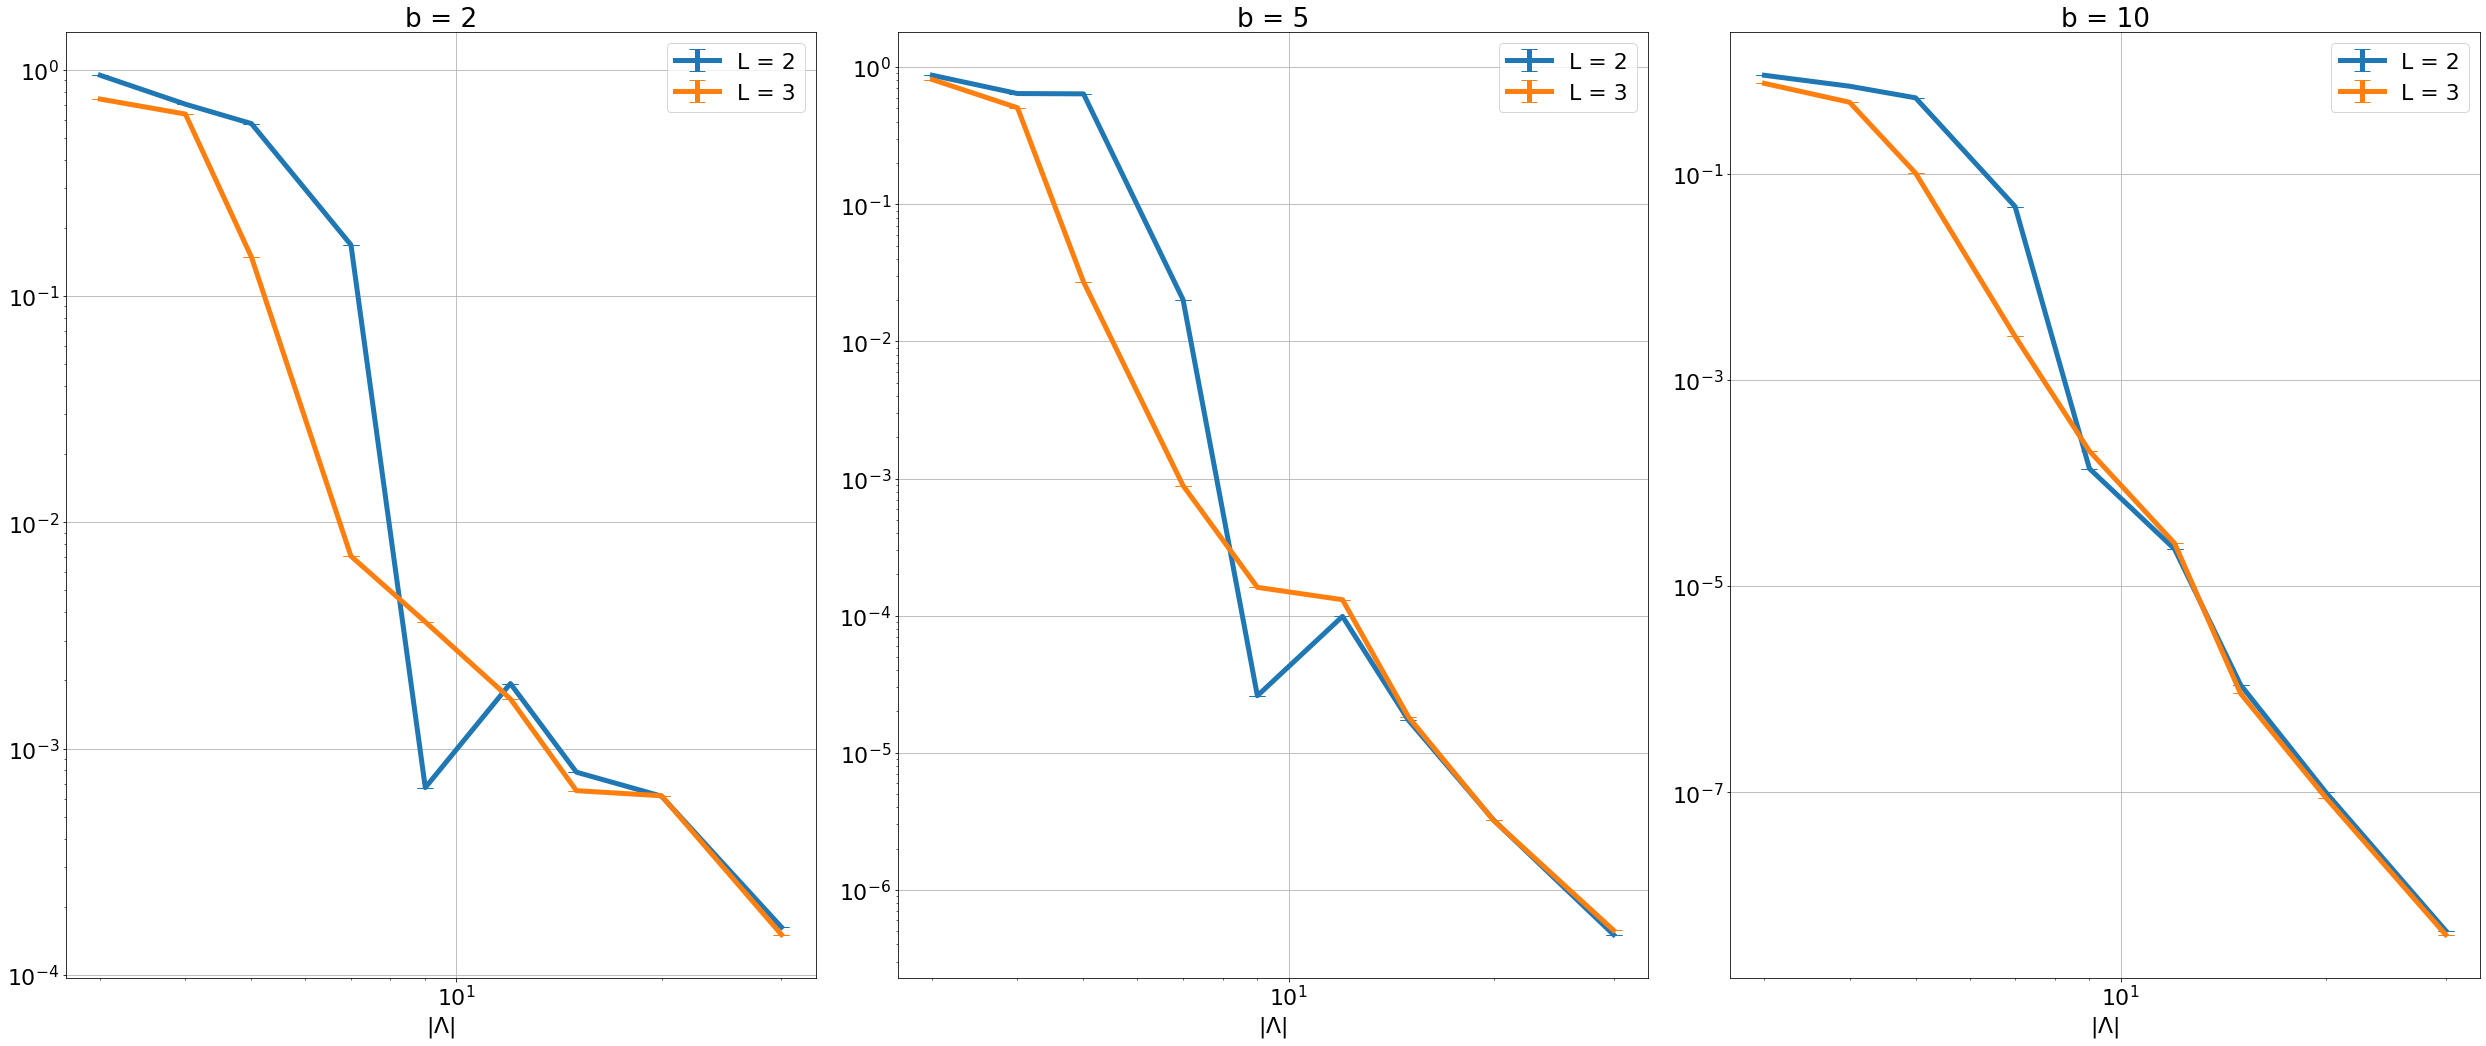

In [2]:
noise = .01
n_runs = 1
result_collection = dict()

epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
x_multis = [m.Size() for m in multis]

Ls = [2,3]
basis = [2,5,10]

points = np.random.uniform(low=-1, high=1, size=(200,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

def compute_l2(indices) : 
    (i,j,k,l) = indices
    deeptm = DeepTransportMap(1, target, [basis[i]**(-Ls[j]+n) for n in range(Ls[j]+1)], multis[k], 'wls')
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    print( i, j, k, l)
    return i, j, k, l, np.sqrt(np.sum((true_target - density)**2))/norm

results_l2 = np.zeros((len(basis), len(Ls), len(multis), n_runs))
with ProcessPoolExecutor(max_workers=7) as executor:
    
    iterable = itertools.product(range(len(basis)), range(len(Ls))[::-1], range(len(multis))[::-1], range(n_runs))
    results = list(executor.map(compute_l2, iterable))
    for (i, j, k, l, l2) in results :
        results_l2[i,j,k,l] = l2
        
fig = plt.figure(figsize=(35,15))
for i in range(len(basis)) :
    ax = plotutil.get_ax(fig, len(basis), i+1, title='b = {}'.format(basis[i]), xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    for j in range(len(Ls)) :
        ax.errorbar(x_multis, np.mean(results_l2[i,j], axis=1), yerr=np.std(results_l2[i,j], axis=1), capsize=8, lw=5, label='L = {}'.format(Ls[j]))
    ax.legend()
plt.tight_layout()
plt.show()

0 1 2 0
0 1 1 0
0 1 3 0
0 1 0 0
0 1 4 0
0 1 5 0
0 0 6 0
0 0 5 0
0 1 6 0
0 0 3 0
0 0 2 0
0 0 4 0
0 0 1 0
0 0 07  00
 0 0
0 1 7 0
1 1 4 0
1 1 5 0
1 1 3 0
1 1 2 0
1 1 0 0
1 1 1 0
1 1 6 0
1 1 7 0
1 0 6 0
1 0 5 0
1 0 3 0
1 0 2 0
1 0 1 0
1 0 4 0
1 0 0 0
1 0 7 0
0 0 8 0
2 1 6 0
2 1 5 0
2 1 3 0
2 1 2 0
2 1 1 0
2 1 4 0
2 1 7 0
2 1 0 0
2 0 6 0
1 0 8 0
2 0 5 0
2 0 4 0
2 0 7 0
2 0 3 0
2 0 2 0
2 0 1 0
2 0 0 0
0 1 8 0
2 0 8 0
1 1 8 0
2 1 8 0


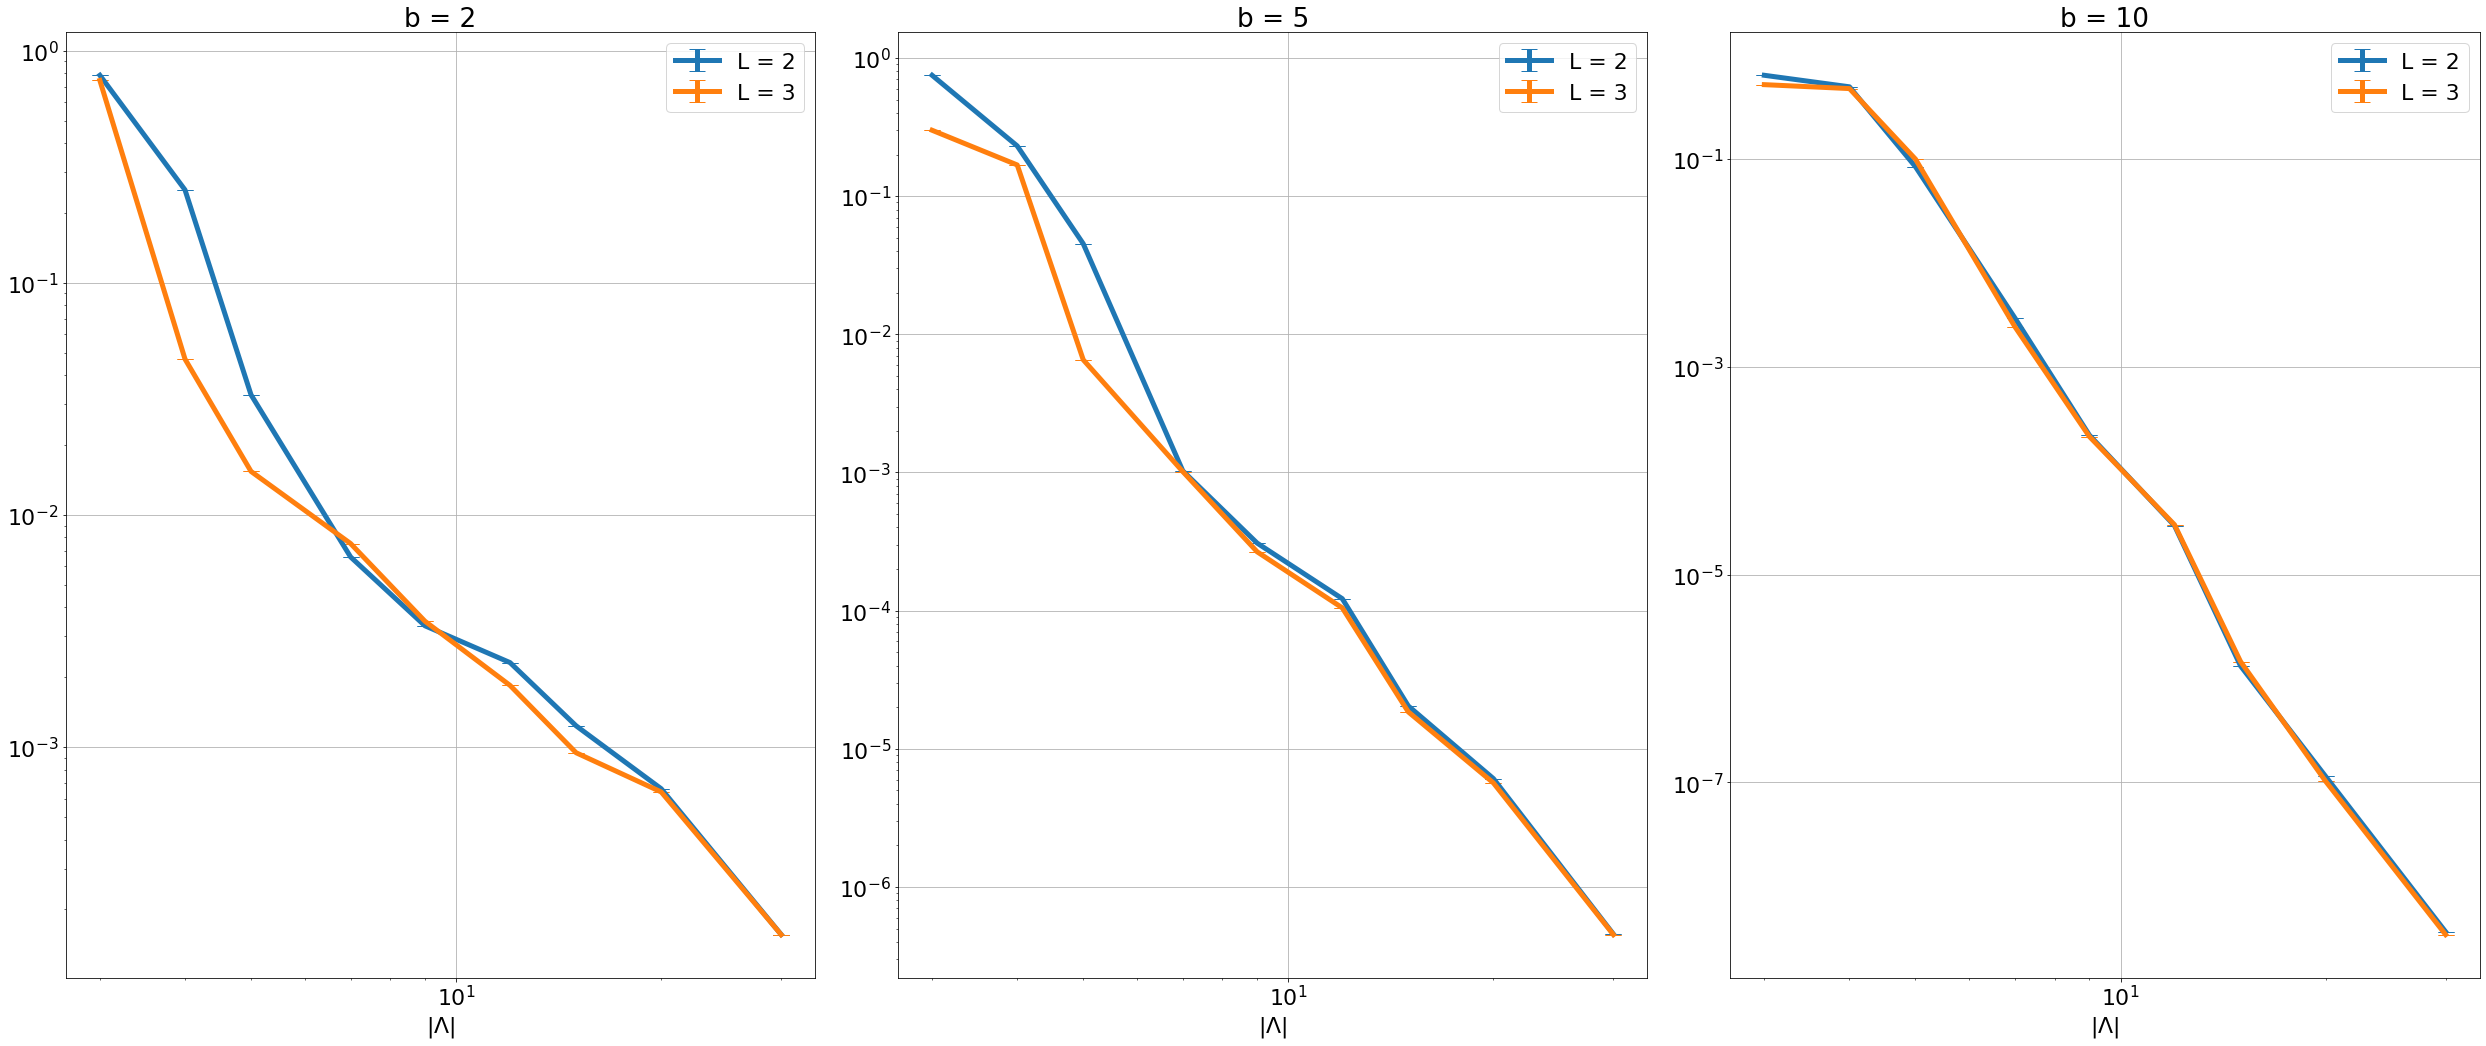

In [3]:
noise = .033
n_runs = 1
result_collection = dict()

epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
x_multis = [m.Size() for m in multis]

Ls = [2,3]
basis = [2,5,10]

points = np.random.uniform(low=-1, high=1, size=(200,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

def compute_l2(indices) : 
    (i,j,k,l) = indices
    deeptm = DeepTransportMap(1, target, [basis[i]**(-Ls[j]+n) for n in range(Ls[j]+1)], multis[k], 'wls')
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    print( i, j, k, l)
    return i, j, k, l, np.sqrt(np.sum((true_target - density)**2))/norm

results_l2 = np.zeros((len(basis), len(Ls), len(multis), n_runs))
with ProcessPoolExecutor(max_workers=7) as executor:
    
    iterable = itertools.product(range(len(basis)), range(len(Ls))[::-1], range(len(multis))[::-1], range(n_runs))
    results = list(executor.map(compute_l2, iterable))
    for (i, j, k, l, l2) in results :
        results_l2[i,j,k,l] = l2
        
fig = plt.figure(figsize=(35,15))
for i in range(len(basis)) :
    ax = plotutil.get_ax(fig, len(basis), i+1, title='b = {}'.format(basis[i]), xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    for j in range(len(Ls)) :
        ax.errorbar(x_multis, np.mean(results_l2[i,j], axis=1), yerr=np.std(results_l2[i,j], axis=1), capsize=8, lw=5, label='L = {}'.format(Ls[j]))
    ax.legend()
plt.tight_layout()
plt.show()

0 1 3 0
0 1 2 0
0 1 0 0
0 1 1 0
0 1 4 0
0 0 7 0
0 1 5 0
0 0 4 0
0 0 6 0
0 0 3 0
0 0 5 0
0 0 2 0
0 0 1 0
0 0 0 0
0 1 6 0
1 1 5 0
1 1 4 0
1 1 3 0
0 1 7 0
1 1 2 0
1 1 0 0
1 1 1 0
1 1 6 0
1 0 6 0
1 0 7 0
1 1 7 0
1 0 4 0
1 01 0  32 0
 0
1 0 0 0
1 0 1 0
1 0 5 0
0 0 8 0
2 1 6 0
2 1 5 0
2 1 3 0
2 1 4 0
2 1 1 0
2 1 2 0
2 1 0 0
2 1 7 0
1 0 8 0
2 0 6 0
2 0 4 0
2 0 3 0
2 0 2 0
2 0 1 0
2 0 0 0
2 0 7 0
2 0 5 0
0 1 8 0
1 1 8 0
2 0 8 0
2 1 8 0


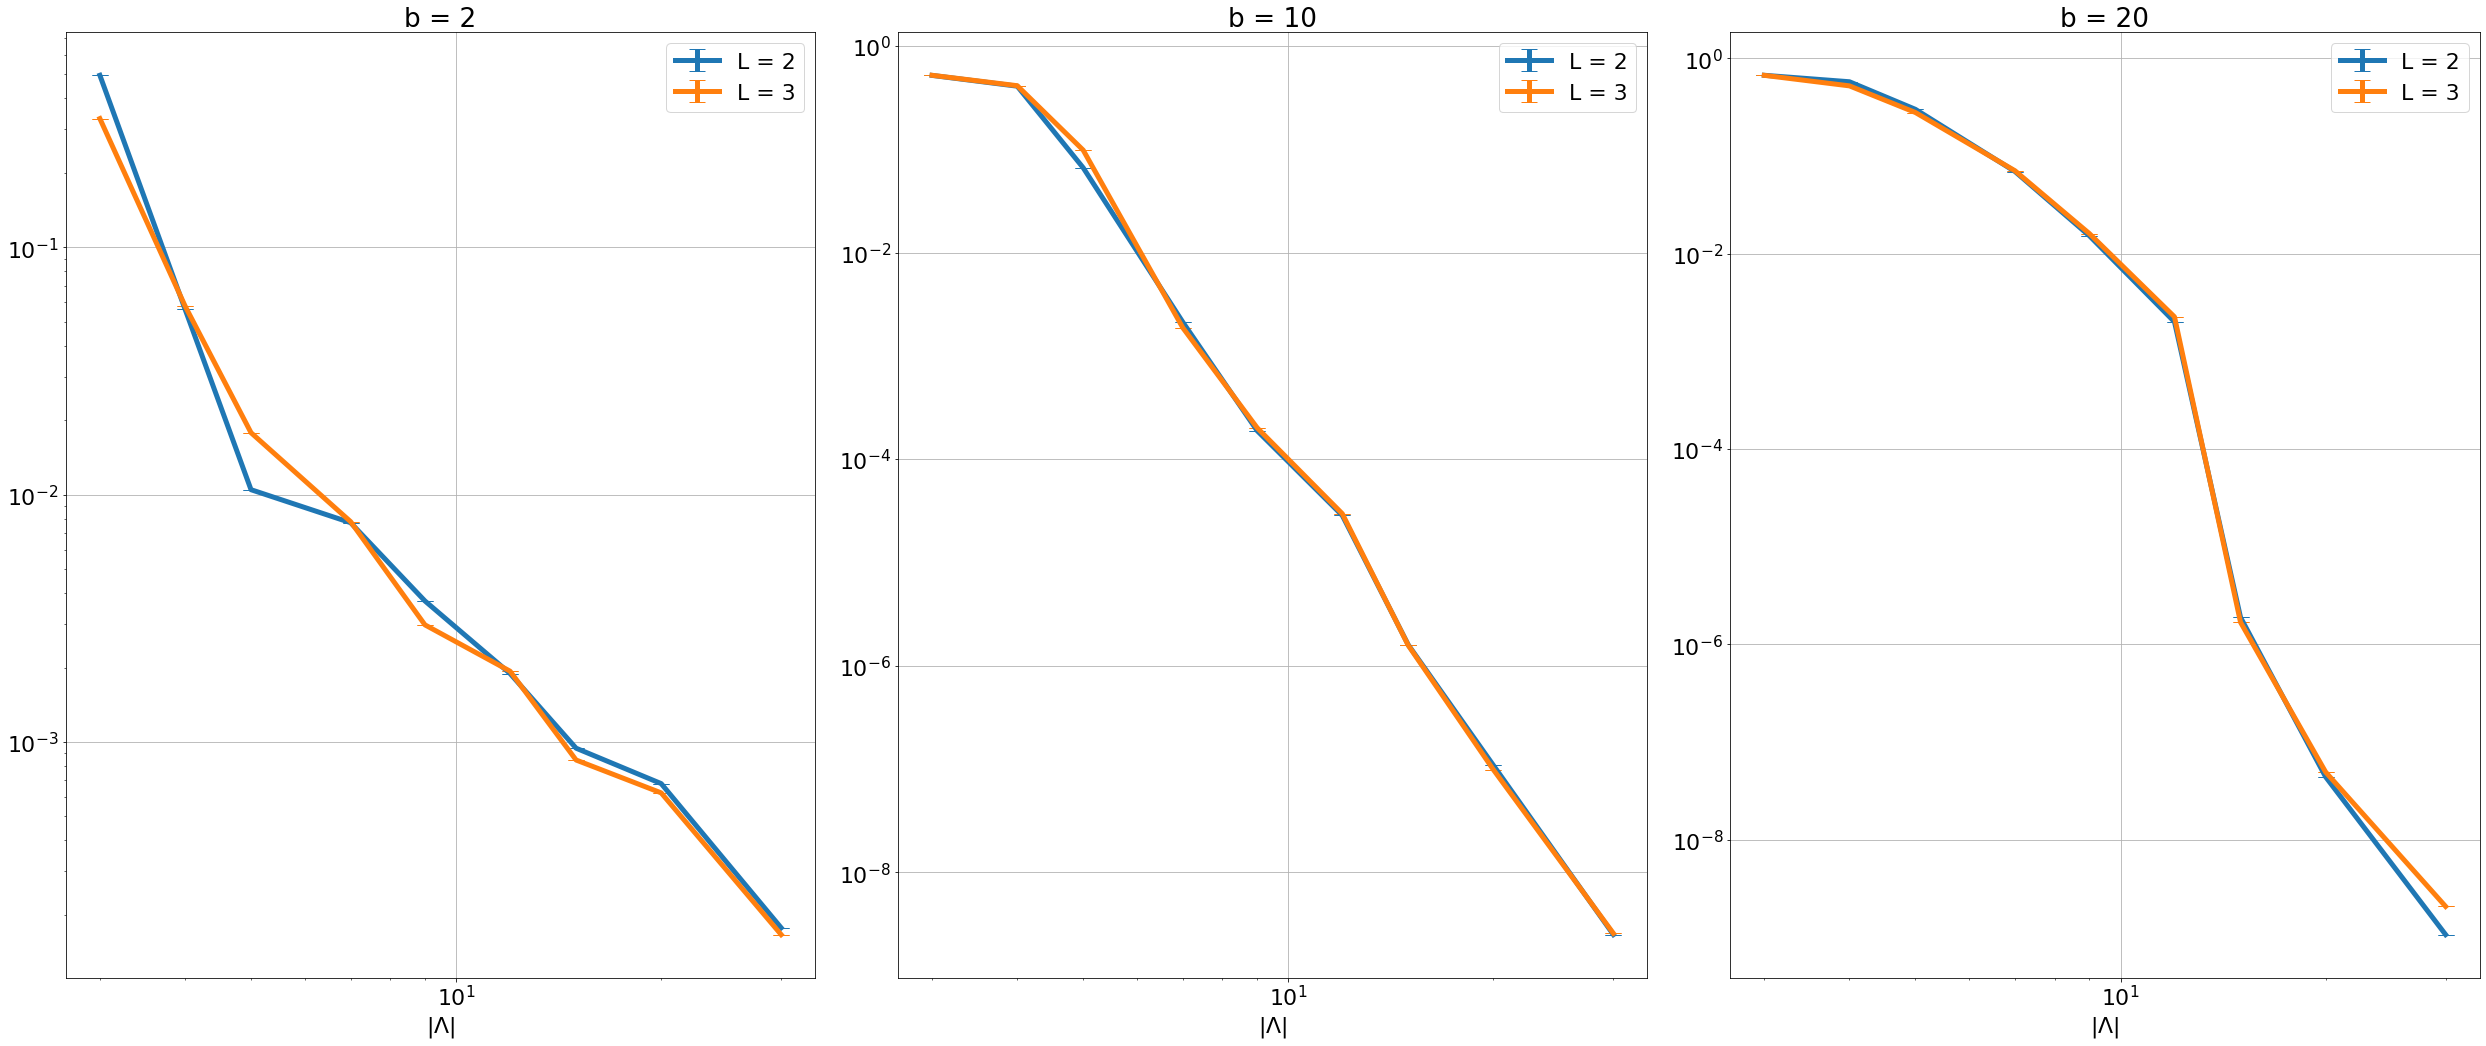

In [4]:
noise = .05
n_runs = 1
result_collection = dict()

epslns = [.4, .3, .2, .1, .05, .015, .005, .001, .00003]
multis = [mu.MultiIndexFactory.CreateAnisotropic([.7], eps) for eps in epslns]
x_multis = [m.Size() for m in multis]

Ls = [2,3]
basis = [2,10,20]

points = np.random.uniform(low=-1, high=1, size=(200,1))

target = GaussianPosterior(noise=noise , y_measurement=[.4])
true_target = np.array([target.Evaluate([xi])[0] for xi in points])[:,0]
true_target /= np.sum(true_target)
norm = np.sqrt(np.dot(true_target, true_target))

def compute_l2(indices) : 
    (i,j,k,l) = indices
    deeptm = DeepTransportMap(1, target, [basis[i]**(-Ls[j]+n) for n in range(Ls[j]+1)], multis[k], 'wls')
    density = [deeptm.density(xi) for xi in points]
    density /= np.sum(density)
    print( i, j, k, l)
    return i, j, k, l, np.sqrt(np.sum((true_target - density)**2))/norm

results_l2 = np.zeros((len(basis), len(Ls), len(multis), n_runs))
with ProcessPoolExecutor(max_workers=7) as executor:
    
    iterable = itertools.product(range(len(basis)), range(len(Ls))[::-1], range(len(multis))[::-1], range(n_runs))
    results = list(executor.map(compute_l2, iterable))
    for (i, j, k, l, l2) in results :
        results_l2[i,j,k,l] = l2
        
fig = plt.figure(figsize=(35,15))
for i in range(len(basis)) :
    ax = plotutil.get_ax(fig, len(basis), i+1, title='b = {}'.format(basis[i]), xlabel=r'$|\Lambda|$', logaxis=['x', 'y'])
    for j in range(len(Ls)) :
        ax.errorbar(x_multis, np.mean(results_l2[i,j], axis=1), yerr=np.std(results_l2[i,j], axis=1), capsize=8, lw=5, label='L = {}'.format(Ls[j]))
    ax.legend()
plt.tight_layout()
plt.show()